# TIDY NOTEBOOK TO MAKE ALL FIGURES FOR PAPER

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response, performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A100-SXM4-80GB'


In [2]:
# Initialize models

"""ReLU + x model with Identity embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    name = "ReluPlusX_NoEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)


"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [3]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99

In [4]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.2751398980617523,
 0.10067866742610931,
 0.10053712874650955,
 0.09995988756418228,
 0.09426074475049973,
 0.10211155563592911,
 0.09408383071422577,
 0.0955749899148941,
 0.09441260993480682,
 0.0974271297454834,
 0.09455479681491852]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

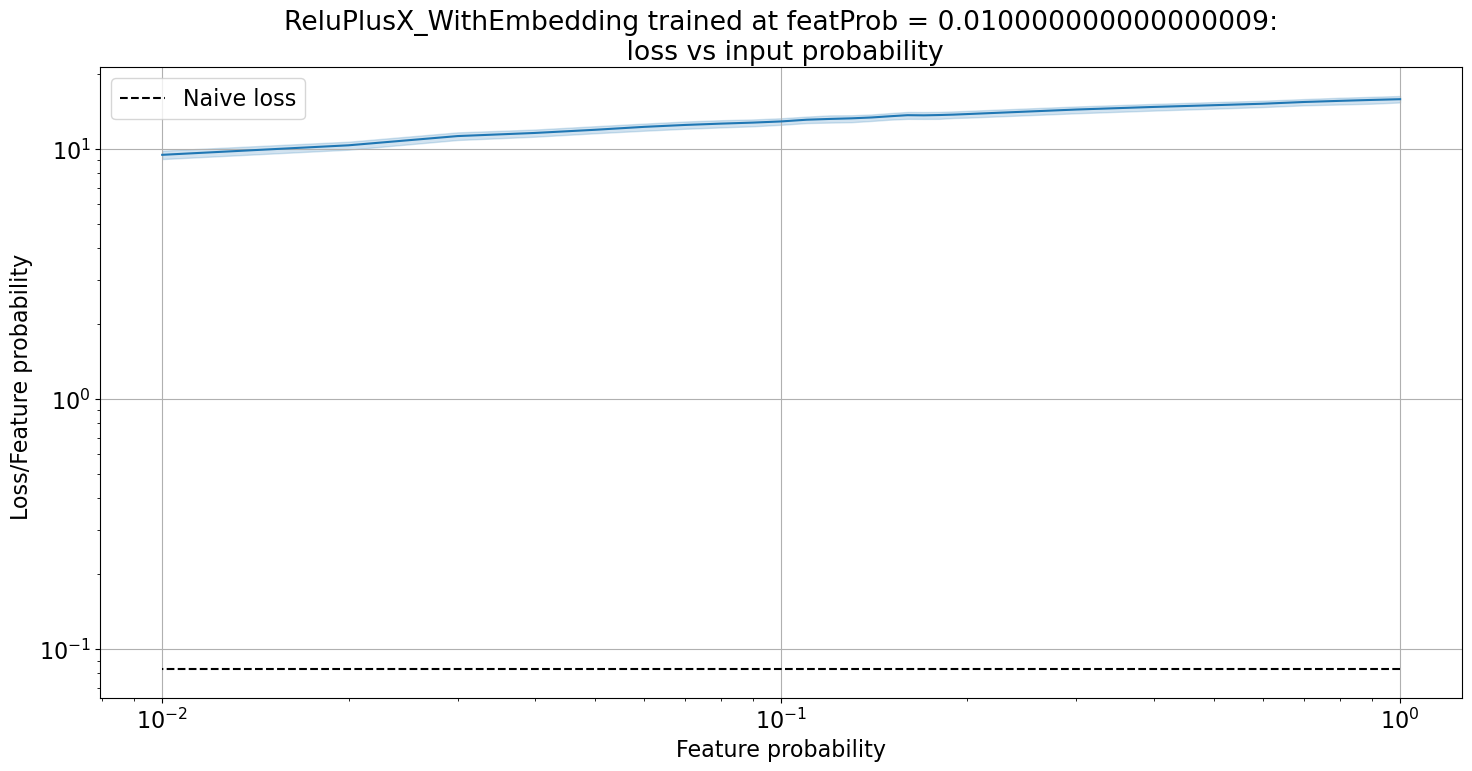

In [5]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

torch.Size([100, 100])


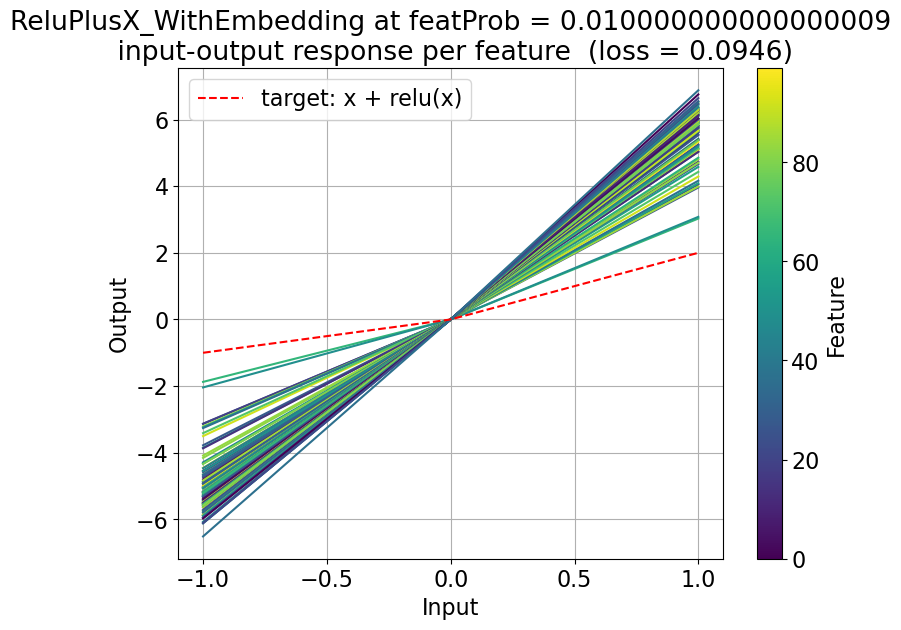

In [6]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

X.shape =  torch.Size([100, 100, 100])
Y.shape =  torch.Size([100, 100, 100])


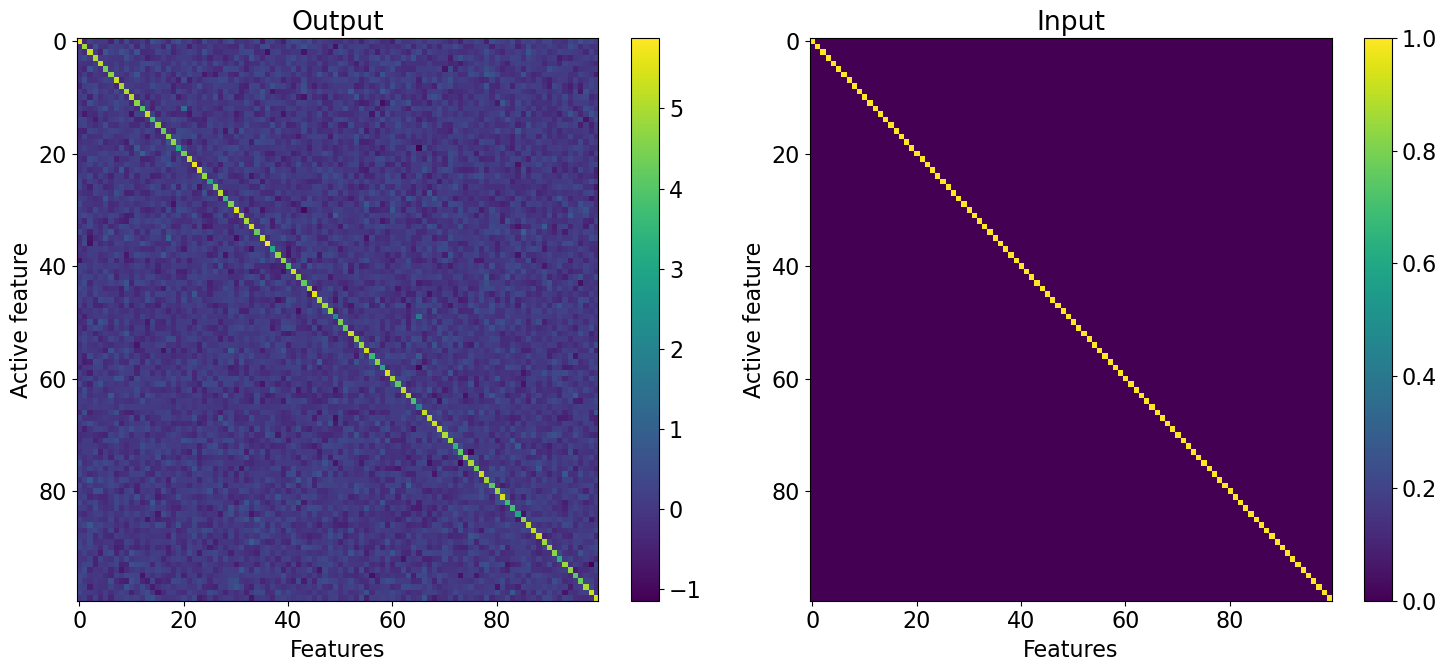

[[ 6.753548   -0.41196394  0.22365396 ...  0.23377983  0.36170977
   0.12725991]
 [-0.22728275  5.811145   -0.31828523 ...  0.08882502 -0.12047733
  -0.09941018]
 [ 0.12979804 -0.26907945  6.2687755  ... -0.35805526  0.28570378
  -0.19611178]
 ...
 [ 0.21884078  0.19082004 -0.5528704  ...  5.9940796   0.3801251
  -0.2653367 ]
 [ 0.37559772  0.03544811  0.03200884 ...  0.18597943  6.2765036
  -0.07691619]
 [-0.04874206  0.1675623  -0.3266874  ... -0.23064509 -0.19246875
   6.356205  ]]


In [7]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

W.shape=torch.Size([100, 50])


<function matplotlib.pyplot.show(close=None, block=None)>

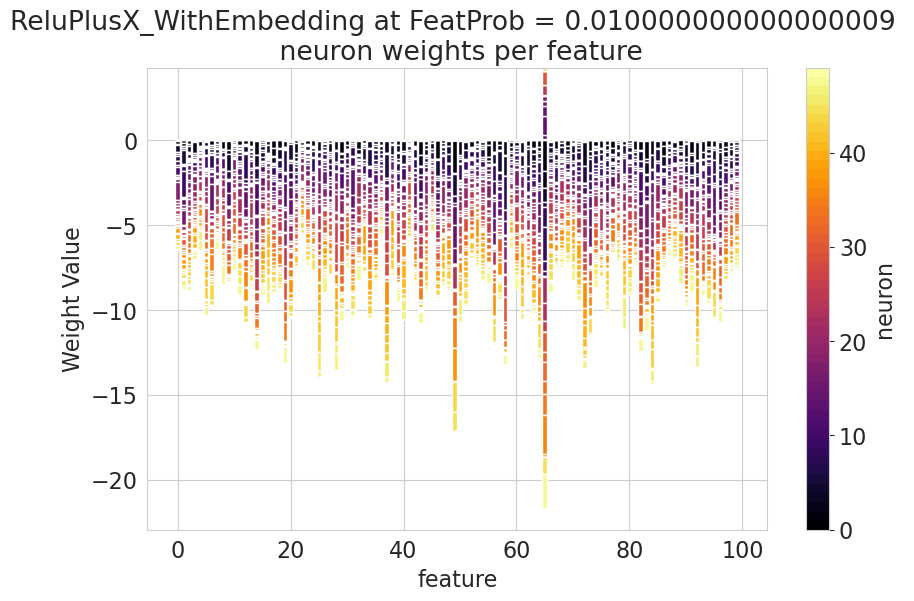

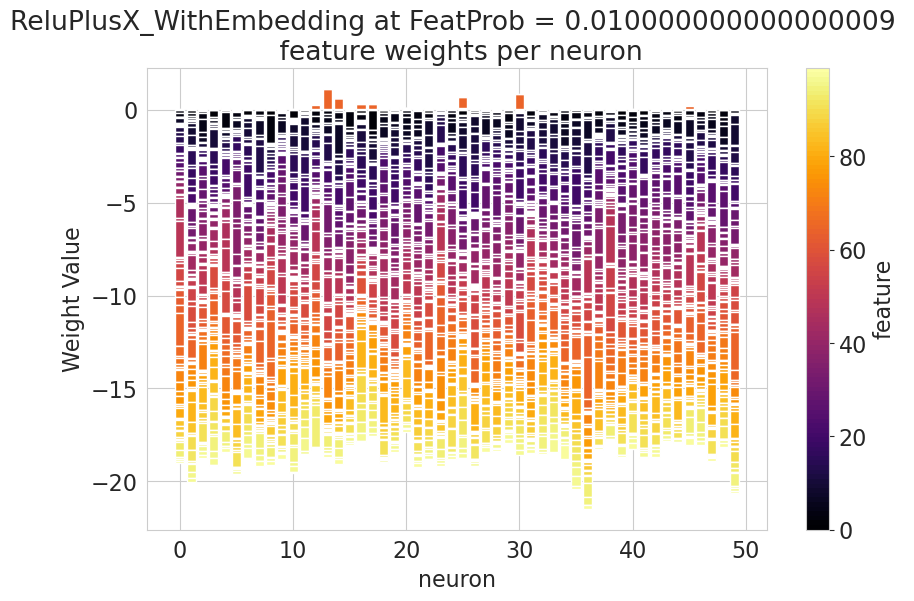

In [8]:
"""Extract and plot weights."""

if model.cfg.We_and_Wu == True: 
    W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
    W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
    W = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")
else:
    W = einsum(model.W1, model.W2, 
               "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show

In [ ]:
plt.figure()
plt.hist(W.detach().cpu().numpy().ravel(), bins=50)
plt.title("histogram of W")
plt.show()

plt.figure()
plt.hist(W_feat_to_neuron.detach().cpu().numpy().ravel(), bins=50)
plt.title("histogram of W_features_to_neuron")
plt.show()

plt.figure()
plt.hist(W_neuron_to_feat.detach().cpu().numpy().ravel(), bins=50)
plt.title("histogram of W_neuron_to_feat")
plt.show()

In [ ]:
"""Plot each weight matrix separately"""

plt.figure()
plt.imshow(model.We.squeeze(0).detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Weight value')
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Heatmap of W_e')
plt.show()

plt.figure()
plt.hist(model.We.squeeze(0).detach().cpu().numpy().ravel(), bins=50)
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Distribution of W_e')
plt.show()

plt.figure()
plt.imshow(model.W1.squeeze(0).detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Weight value')
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Heatmap of W_1')
plt.show()

plt.figure()
plt.hist(model.W1.squeeze(0).detach().cpu().numpy().ravel(), bins=50)
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Distribution of W_1')
plt.show()

plt.figure()
plt.imshow(model.W2.squeeze(0).detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Weight value')
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Heatmap of W_2')
plt.show()

plt.figure()
plt.hist(model.W2.squeeze(0).detach().cpu().numpy().ravel(), bins=50)
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Distribution of W_2')
plt.show()

plt.figure()
plt.imshow(model.Wu.squeeze(0).detach().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Weight value')
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Heatmap of W_u')
plt.show()

plt.figure()
plt.hist(model.Wu.squeeze(0).detach().cpu().numpy().ravel(), bins=50)
plt.xlabel("Input dimension")
plt.ylabel("Output dimension")
plt.title('Distribution of W_u')
plt.show()

In [ ]:
"""Plot activation values when 1 feature vs 2 features active"""


device = t.device("cuda" if t.cuda.is_available() else "cpu")

# --- 1) Identify a feature pair that shares a strong neuron in W1 ---
W1 = model.W1.squeeze(0).detach().cpu().numpy()  # shape: (n_hidden, n_input)
W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
M = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")

# choose which weight matrix we're gonna look at
W = W_feat_to_neuron.squeeze(0).detach().cpu().numpy()
hidden_dim = 50
input_dim = 100
print('W.shape = ', W.shape)

# Pick a threshold for “strong” weights
thr = np.percentile(np.abs(W1), 90)

pair = None
for i in range(input_dim):
    for j in range(i+1, input_dim):
        mask_i = np.abs(W[:, i]) > thr
        mask_j = np.abs(W[:, j]) > thr
        if np.any(mask_i & mask_j):
            pair = (i, j)
            break
    if pair:
        break
if not pair:
    raise RuntimeError("No strong‐shared‐neuron pair found; lower the threshold.")

v1, v2 = pair
print(f"Using feature pair: v1={v1}, v2={v2}")

# --- 2) Build sparse input vectors ---
def make_sparse_input(active_feats):
    x = t.zeros(100, device=device)
    x[active_feats] = 1.0
    return x

x1 = make_sparse_input([v1])             # only v1
x2 = make_sparse_input([v1, v2])         # v1 and v2

# reshape to model’s expected shape: (batch, inst, feat)
# i.e. batch=1, inst=1, feat=input_dim
X1 = x1.unsqueeze(0).unsqueeze(1)
X2 = x2.unsqueeze(0).unsqueeze(1)

# --- 3) Manual forward pass to capture hidden activations ---
def forward_with_hidden(X):
    # X: (1, 1, input_dim)
    cfg = model.cfg
    # embedding
    if cfg.We_and_Wu:
        print('model.We.shape = ', model.We.shape)
        print('X.shape = ', X.shape)
        E = t.einsum("b i f, i e f -> b i f", X, model.We)
    else:
        E = X  # no embed
    # first linear → (1,1,hidden_dim)
    H_pre = t.einsum("b i f, i h e -> b i h", E, model.W1)  # pre‐ReLU
    H = F.relu(H_pre)
    # second linear
    Z = t.einsum("b i h, i o h -> b i o", H, model.W2)
    # unembedding
    if cfg.We_and_Wu:
        Y = t.einsum("b i o, i e o -> b i e", Z, model.Wu)
    else:
        Y = Z
    # squeeze to vectors
    hidden_vec = H.squeeze(0).squeeze(0).detach().cpu().numpy()   # shape (hidden_dim,)
    output_vec = Y.squeeze(0).squeeze(0).detach().cpu().numpy()   # shape (output_dim or input_dim)
    return hidden_vec, output_vec

model.eval()
with t.no_grad():
    h1, y1 = forward_with_hidden(X1)
    h2, y2 = forward_with_hidden(X2)

# --- 4) Inspect and plot ---
print("Output with only v1:", y1)
print("Output with v1+v2:", y2)

# Hidden activations
plt.figure(figsize=(10,4))
plt.plot(h1, label=f"only feature {v1}")
plt.plot(h2, label=f"features {v1}+{v2}")
plt.xlabel("Hidden neuron index")
plt.ylabel("Activation (post‑ReLU)")
plt.title("Hidden activations: single vs. paired features")
plt.legend()
plt.show()

# Delta activations
plt.figure(figsize=(10,3))
plt.bar(np.arange(hidden_dim), h2 - h1)
plt.xlabel("Hidden neuron index")
plt.ylabel("Δ activation")
plt.title(f"Change in hidden activations when adding feature {v2}")
plt.show()



In [ ]:
"""Plot a phase diagram of loss of training sparsity vs input sparsity performance"""

"""Choose model and specify sparsities to explore"""
model_cfg = reluPlusX_res_embed_cfg

sparsities = np.array([0.1, 0.3,0.5,0.7,0.8,0.85, 0.9,0.95,0.99])

"Hyperparameters"
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# Iterate over training sparsities
loss_data = []
for feat_sparsity in sparsities: 

    model = Cis(model_cfg, device=device).to(device)
    n_steps = 2000 / (1-feat_sparsity)
    n_steps = n_steps.astype(int)
    logging_freq = n_steps // 10

    """Train the model at a given sparsity"""
    losses = model.train_reluPlusX(
            batch_sz,
            feat_sparsity,
            feat_importance,
            n_steps,
            lr, 
            logging_freq, 
    )

    """Test this model's performance across a range of sparsities"""
    loss_data = performance_across_sparsities(sparsities, model, loss_data, feat_sparsity)

# Show plot
fig = plot_phase_diagram (loss_data, model.cfg.name)
filename = f"/workspace/{model.cfg.name}_phase_diagram_loss.png"
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Plot training sparsity vs training steps + loss and polysemanticity"""

"Choose model, in this case only identity embedding"
model_cfg = reluPlusX_res_noEmbed_cfg

train_sparsities = np.array([0.5, 0.75, 0.90, 0.95, 0.99])
sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
steps = np.array([1000, 2000, 3000, 5000, 8000, 12000, 20000, 32000, 52000])
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# Iterate over training sparsities
loss_data = []
poly_data = []
eval_data = []
for feat_sparsity in train_sparsities:
    n_steps = 1
    """Train the model at a given sparsity"""
    model = Cis(model_cfg, device=device).to(device)
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    while n_steps <= steps[-1]:
        x, y_true = model.gen_batch_reluPlusX(batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = model.loss_fn_reluPlusX(y, y_true, feat_importance)
        
        # Update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * n_steps / (steps[-1] - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # check if the current step is an evaluation step and extract loss and polysemanticity
        if n_steps in steps:
            
            """Store loss at last training step"""
            loss_data.append({"sparsity": feat_sparsity, "n_steps": n_steps,
                          "loss": loss.item()})
            
            """Store average feature weights per neuron"""
            if model.cfg.We_and_Wu == True:
                W_feat_to_neuron = einsum(model.We, model.W1,
                                      "inst emb feat, inst neuron emb -> neuron feat")
                W_neuron_to_feat = einsum(model.W2, model.Wu,
                                      "inst emb neuron, inst feat emb -> feat neuron")
                W = einsum(W_feat_to_neuron, W_neuron_to_feat,
                           "neuron feat, feat neuron -> feat neuron")
            else:
                W = einsum(model.W1, model.W2,
                   "inst neuron feature, inst feature neuron-> neuron feature")
            W = threshold_matrix(W.squeeze(), threshold=0.001)
            features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1)
            del W
            poly_data.append({"sparsity":feat_sparsity, "n_steps": n_steps, 
                              "features_per_neuron": features_per_neuron})

            """Compute performance across sparsities"""
            eval_data = performance_across_sparsities(sparsities, model, eval_data, feat_sparsity, n_steps)
            
        # add an extra step and continue
        n_steps += 1

fig = plot_phase_diagram_training(loss_data, model.cfg.name)
filename = f"/workspace/{model.cfg.name}_phase_diagram_loss.png"
plt.savefig(filename, dpi=300)
plt.show()

fig = plot_phase_diagram_polysem(poly_data, model.cfg.name)
filename = f"/workspace/{model.cfg.name}_phase_diagram_polysem.png"
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
df_loss = pd.DataFrame(eval_data)
df_loss["featProbs"] = np.round(1 - df_loss["input_sparsity"],2)
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["input_sparsity"])

unique_A = df_loss['train_sparsity'].unique()
n_plots = len(unique_A)

naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
norm_loss = naive_loss.ravel() / (1 - sparsities)

fig, axes = plt.subplots(n_plots, 1, figsize=(10, 7 * n_plots), sharex=True)

# Ensure axes is iterable even if there's only one subplot
if n_plots == 1:
    axes = [axes]

for ax, a_val in zip(axes, unique_A):
    subset = df_loss[df_loss['train_sparsity'] == a_val]
    sns.lineplot(data=subset, x='featProbs', y='loss/1-S', hue='n_steps', ax=ax, palette='colorblind')
    ax.axhline(y=norm_loss[0], linestyle="dashed", color="black", label=r"Naive loss") 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()
    ax.legend(loc = "best", fontsize = 12)
    ax.set_ylabel('Adjusted loss (loss / p)')
    ax.set_xlabel('Evaluation feature probability')
    ax.set_title(f"training Feature Probability = {1 - a_val:.2f}")

plt.tight_layout()
plt.show()